# Exercício 2

Importações

In [1]:
import pandas as pd
import math
import numpy as np
from tqdm import tqdm


Primeiro foi feita a função para converter gray para binário. Como o nosso espaço de fenótipos é com numeros reais, faz sentido usar gray para não termos problemas com hamming cliffs.

In [2]:
def gray_to_binary(gray_bits):
    binary = [gray_bits[0]]
    for i in range(1, len(gray_bits)):
        binary.append(binary[i-1] ^ gray_bits[i])
    return binary


Depois a função mapeando binário para real

In [3]:

def binario_para_real(bin_bits, x_min, step):
    k = int(''.join(map(str, bin_bits)), 2)
    x = x_min + step * k
    return x

A função objetivo do problema:

In [4]:
def rastrigin(x):
    x = np.array(x)
    n = len(x)
    return 10 * n + np.sum(x**2 - 10 * np.cos(2 * np.pi * x))

Na função de fitness foi utilizada a estratégia de usar um Cmax - função objetivo.
A principio tinha sido aplicado apenas a inversão da variável visto que a imagem da função objetivo é toda positiva, invertendo os valores garantimos que o melhor vai ter uma aptidão maior. Contudo, os valores piores vão ser escalarmente maiores e isso é ruim para calcular as probabilidades para fazer escolha de melhores individuos. Para corrigir isso todos os valores deveriam ser positivos. Como o problema está limitado com xmin = -5.12 e xmax = 5.12 e sabemos que o minimo da função é 0, podemos calcular um maximo teórico para era e usar o cmax para garantir que todo fitness seja positivo e que os melhores valores sejam maiores.

In [5]:

def fitness_function(population):
    fitness_array = []
    for n in population:
        x = []
        for gene in range(n_dim):
            bits_gene = n[bits_precision * gene : bits_precision * (gene + 1)]
            bits_binarios = gray_to_binary(bits_gene)
            valor_real = binario_para_real(bits_binarios, x_min, step)
            x.append(valor_real)
        fitness = C_max - rastrigin(x)
        fitness_array.append(fitness)
    return np.array(fitness_array)

Implementação da roleta

In [6]:
def roleta(population, fitness_array):
    prob = fitness_array/fitness_array.sum()
    selected_idx = np.random.choice(len(population), p=prob)
    return population[selected_idx]

Implementação do torneio

In [7]:
def torneio(population, fitness_array, tournament_size=2):
    selected_idx = np.random.choice(len(population), size=tournament_size, replace=False)
    best_idx = selected_idx[np.argmax(fitness_array[selected_idx])]
    return population[best_idx]

Função para selecionar os pais. Tem 50% de chance de usar torneio e 50% de chance de usar roleta.

In [8]:
def selecionar_pais(population, fitness_array, tournament_size=2):
    selected = []
    for _ in range(len(population)):
        if np.random.rand() < 0.5:
            ind = roleta(population, fitness_array)
        else:
            ind = torneio(population, fitness_array, tournament_size)
        selected.append(ind)
    return selected

Função para fazer o crossover. É selecionado um ponto aleatório pra fazer divisão por variável. Cada variável pode ter um ponto de corte diferente.

In [9]:
def crossover(pai_1,pai_2):
    filho_1,filho_2 =[],[]
    for n in range(n_dim):
        var_1 = pai_1[n*bits_precision:(n+1)*bits_precision]
        var_2 = pai_2[n*bits_precision:(n+1)*bits_precision]
        corte = np.random.randint(bits_precision-1)+1
        filho_1 += var_1[:corte] + var_2[corte:]
        filho_2 += var_2[:corte] + var_1[corte:]
    return [filho_1, filho_2]

Função para mutação que usa o p_mutation para fazer o bitflip. É calculado para todos os bits para cada individuo.

In [10]:

def mutation(individual):
    return [1-i if np.random.rand() < p_mutation else i for i in individual]

Definição dos parametros do problema

In [11]:
# Parâmetros do problema
n_dim = 10 # dimensão por individuo (especificado no enunciado)
x_min = -5.12 # valor mínimo de x (especificado no enunciado)
x_max = 5.12 # valor máximo de x (especificado no enunciado)
bits_precision = 12   # quantidade de bits para representar o valor real

# Derivando o step automaticamente
x_intervalo = x_max - x_min
step = x_intervalo / (2**bits_precision - 1)
print(f"Step (incremento entre valores): {step:.6f}")

# Total de bits por indivíduo
n_bits = bits_precision * n_dim
print(f"Número total de bits por indivíduo: {n_bits}")

# Parâmetros do algoritmo genético
pop_size = 30 # tamanho da população 
max_evals = 1e5 # numero de avaliações (especificado no enunciado)
max_geracoes = int(max_evals / pop_size) # usando a população para calcular o numero de geracoes maximo
tournament_size = 2 # numero de individuos para o torneio
p_mutation = 0.005 # probabilidade de mutação
p_crossover = 0.6 # probabilidade de crossover
elitismo = True # se True, o melhor individuo da geração atual vai ser mantido na proxima geracao
# C_max é calculado para o pior caso da função Rastrigin, garantindo fitness positivo
C_max = round(10 * n_dim + n_dim * (x_max**2 + 10) + 5)
print(f"Valor de C_max para garantir fitness positivo: {C_max}")
# Criando a população inicial com individuos aleatorios
population = [np.random.randint(0, 2, n_bits).tolist() for _ in range(pop_size)]
print(max_geracoes)

# Inicializando listas para armazenar o histórico
historico_fitness = []
historico_individuos = []
historico_geracoes = []
historico_objetivo = []

# Loop para cada geração
for geracao in tqdm(range(max_geracoes)):
    fitness_array = fitness_function(population)

    # Registro dos melhores
    best_idx = np.argmax(fitness_array)
    melhor_fitness = fitness_array[best_idx]
    melhor_individuo = population[best_idx]
    
    # Converte melhor indivíduo para valores reais e calcula rastrigin
    x = []
    for gene in range(n_dim):
        bits_gene = melhor_individuo[bits_precision * gene : bits_precision * (gene + 1)]
        bits_binarios = gray_to_binary(bits_gene)
        valor_real = binario_para_real(bits_binarios, x_min, step)
        x.append(valor_real)
    melhor_objetivo = rastrigin(x)  # Calcula direto o rastrigin sem subtrair de C_max

    historico_fitness.append(melhor_fitness)
    historico_individuos.append(melhor_individuo)
    historico_geracoes.append(geracao)
    historico_objetivo.append(melhor_objetivo)

    # Seleção
    pais = selecionar_pais(population, fitness_array)
    np.random.shuffle(pais)

    # Crossover
    filhos = []
    for i in range(0, len(pais), 2):
        pai1, pai2 = pais[i], pais[i+1]
        if np.random.rand() < p_crossover:
            filho1, filho2 = crossover(pai1, pai2)
        else:
            filho1, filho2 = pai1, pai2
        filhos.extend([filho1, filho2])

    # Mutação
    nova_geracao = [mutation(filho) for filho in filhos]

    if elitismo:
        fitness_nova = fitness_function(nova_geracao)
        worst_idx = np.argmin(fitness_nova)
        nova_geracao[worst_idx] = melhor_individuo.copy()

    population = nova_geracao


Step (incremento entre valores): 0.002501
Número total de bits por indivíduo: 120
Valor de C_max para garantir fitness positivo: 467
3333


100%|██████████| 3333/3333 [00:09<00:00, 354.18it/s]


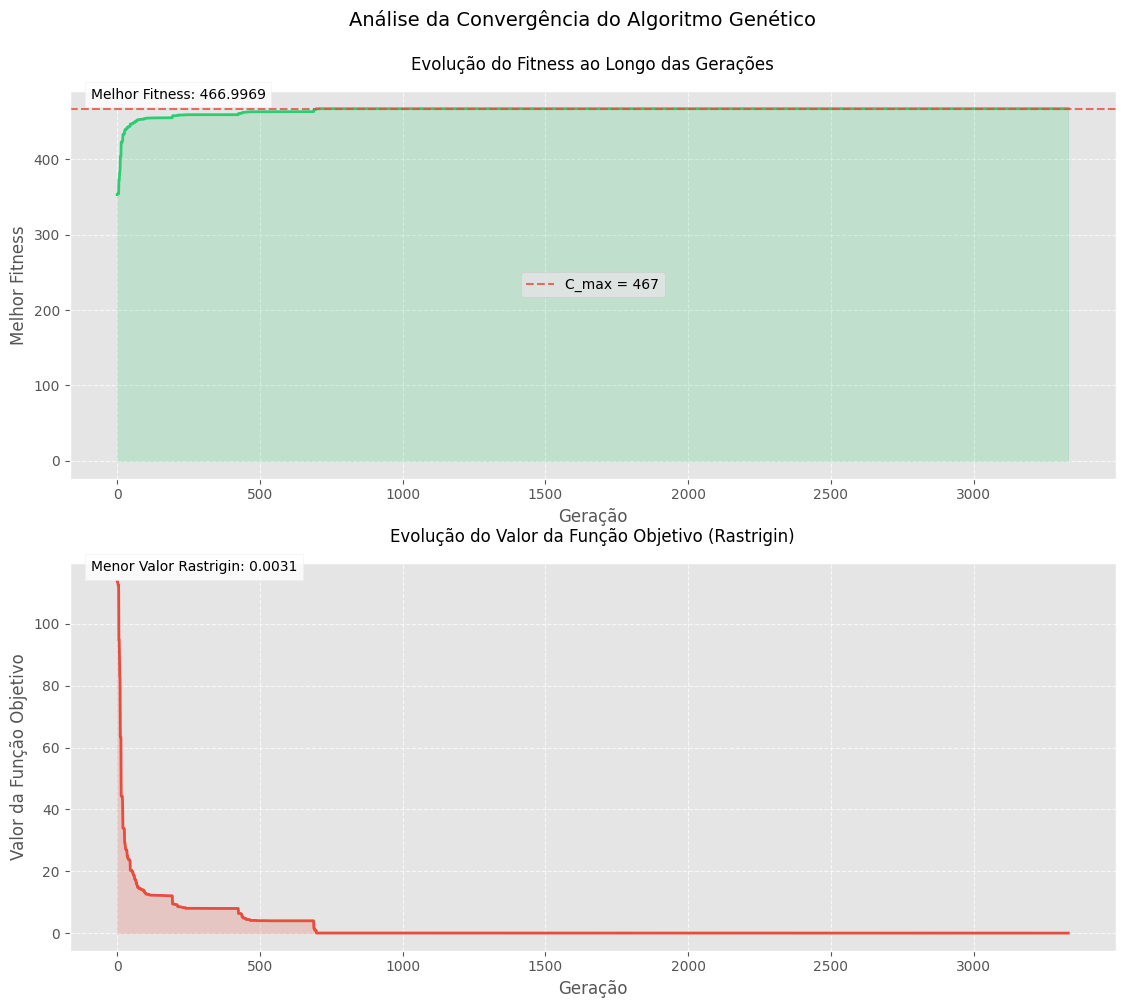

In [12]:
import matplotlib.pyplot as plt

# Configurar o estilo
plt.style.use('ggplot')  # Usando um estilo built-in do matplotlib

# Criar figura com subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
fig.tight_layout(pad=4.0)

# Subplot 1: Evolução do Fitness
ax1.plot(historico_geracoes, historico_fitness, linewidth=2, color='#2ecc71')
ax1.fill_between(historico_geracoes, historico_fitness, alpha=0.2, color='#2ecc71')
ax1.axhline(y=C_max, color='#e74c3c', linestyle='--', alpha=0.8, label=f'C_max = {C_max}')
ax1.set_title('Evolução do Fitness ao Longo das Gerações', fontsize=12, pad=15)
ax1.set_xlabel('Geração')
ax1.set_ylabel('Melhor Fitness')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend()

# Subplot 2: Evolução da Função Objetivo (Rastrigin)
ax2.plot(historico_geracoes, historico_objetivo, linewidth=2, color='#e74c3c')
ax2.fill_between(historico_geracoes, historico_objetivo, alpha=0.2, color='#e74c3c')
ax2.set_title('Evolução do Valor da Função Objetivo (Rastrigin)', fontsize=12, pad=15)
ax2.set_xlabel('Geração')
ax2.set_ylabel('Valor da Função Objetivo')
ax2.grid(True, linestyle='--', alpha=0.7)

# Ajustar layout e adicionar título geral
fig.suptitle('Análise da Convergência do Algoritmo Genético', fontsize=14, y=1.02)

# Adicionar informações finais
ax1.text(0.02, 0.98, f'Melhor Fitness: {historico_fitness[-1]:.4f}', 
         transform=ax1.transAxes, bbox=dict(facecolor='white', alpha=0.8))
ax2.text(0.02, 0.98, f'Menor Valor Rastrigin: {historico_objetivo[-1]:.4f}', 
         transform=ax2.transAxes, bbox=dict(facecolor='white', alpha=0.8))

plt.show()

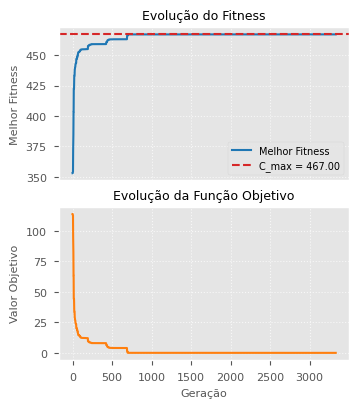

In [13]:
import matplotlib.pyplot as plt
import numpy as np # Necessário para o exemplo

# --- Dados de Exemplo (substitua pelos seus dados reais) ---
# historico_geracoes = np.arange(50)
# historico_fitness = 100 * (1 - np.exp(-historico_geracoes / 10)) + np.random.rand(50) * 5
# historico_objetivo = 50 * np.exp(-historico_geracoes / 8) + np.random.rand(50) * 3
# C_max = 100
# -----------------------------------------------------------

# --- Configurações para formato IEEE ---
# Estilo mais limpo e tamanhos de fonte menores
plt.style.use('seaborn-v0_8-paper') # Um estilo bom para artigos
plt.rcParams.update({
    'font.size': 8,          # Tamanho base da fonte
    'axes.labelsize': 8,
    'axes.titlesize': 9,     # Títulos um pouco maiores
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 7,    # Legenda ainda menor
    'figure.titlesize': 10,
    'lines.linewidth': 1.5,  # Linhas um pouco mais finas
    'axes.grid': True,
    'grid.linestyle': ':',   # Grid pontilhado (menos intrusivo)
    'grid.alpha': 0.7,
    # Para fontes tipo LaTeX (opcional, requer LaTeX instalado)
    # 'text.usetex': True,
    # 'font.family': 'serif',
    # 'font.serif': ['Computer Modern Roman'], # ou Times New Roman
})

# --- Criação da Figura ---
# Ajuste o figsize: a largura deve ser próxima à largura da coluna (~3.5 polegadas)
# A altura pode ser ajustada para manter a proporção e legibilidade.
# Usar sharex=True é bom para plots empilhados com o mesmo eixo X.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(3.5, 4.0), sharex=True)

# Subplot 1: Evolução do Fitness
ax1.plot(historico_geracoes, historico_fitness, color='tab:blue', label='Melhor Fitness')
# ax1.fill_between(...) # Removido para simplicidade, pode adicionar com alpha baixo se necessário
ax1.axhline(y=C_max, color='tab:red', linestyle='--', label=f'C_max = {C_max:.2f}') # Formatar valor
# Títulos mais curtos e diretos
ax1.set_title('Evolução do Fitness')
# O label do eixo X será definido apenas no último subplot (ax2) devido ao sharex=True
ax1.set_ylabel('Melhor Fitness')
ax1.legend(loc='lower right') # Posição da legenda para não atrapalhar
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) # Remover ticks X do plot superior

# Subplot 2: Evolução da Função Objetivo (Rastrigin)
ax2.plot(historico_geracoes, historico_objetivo, color='tab:orange', label='Valor Objetivo')
# ax2.fill_between(...) # Removido para simplicidade
ax2.set_title('Evolução da Função Objetivo')
ax2.set_xlabel('Geração')
ax2.set_ylabel('Valor Objetivo')
# ax2.legend() # Legenda pode ser desnecessária se claro pelo título/cor

# --- Ajustes Finais ---
# Remover textos flutuantes, a informação deve estar na legenda ou caption do artigo
# ax1.text(...) # Removido
# ax2.text(...) # Removido

# Remover título geral da figura, geralmente desnecessário em subplots para artigos
# fig.suptitle(...) # Removido

# Ajustar espaçamento entre subplots
plt.tight_layout(pad=0.5) # Reduzir padding
# Alternativamente, controle manual:
# fig.subplots_adjust(hspace=0.3) # Ajusta espaço vertical

# Salvar em formato adequado para artigos (alta resolução ou vetor)
# plt.savefig('convergencia_genetico_ieee.pdf', dpi=300, bbox_inches='tight')
plt.savefig('images/av1/convergencia_genetico_ieee.png', dpi=300, bbox_inches='tight')

plt.show()

### Experimentação com os parametros

Grid search para busca dos melhores parametros.

In [14]:
import itertools
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime

# Parâmetros fixos do problema
n_dim = 10
x_min = -5.12
x_max = 5.12
bits_precision = 12
x_intervalo = x_max - x_min
step = x_intervalo / (2**bits_precision - 1)
n_bits = bits_precision * n_dim
tournament_size = 2
elitismo = True
max_evals = 1e5

# Parâmetros para o grid search
pop_sizes = [30, 50, 100, 500]
mutation_rates = [0.005, 0.01, 0.05, 0.1]
crossover_rates = [0.4, 0.5, 0.6, 0.7, 0.8]
n_simulations = 5

# Lista para armazenar resultados
results = []

# Gerando todas as combinações possíveis
parameter_combinations = list(itertools.product(pop_sizes, mutation_rates, crossover_rates))

# Barra de progresso para todas as execuções
total_executions = len(parameter_combinations) * n_simulations
progress_bar = tqdm(total=total_executions, desc="Grid Search Progress")


for pop_size, p_mutation, p_crossover in parameter_combinations:
    # Recalculando max_geracoes baseado no pop_size
    max_geracoes = int(max_evals / pop_size)
    
    # C_max recalculado para cada simulação
    C_max = round(10 * n_dim + n_dim * (x_max**2 + 10) + 5)
    
    for sim in range(n_simulations):
        start_time = time.time()
        
        # Inicializando população
        population = [np.random.randint(0, 2, n_bits).tolist() for _ in range(pop_size)]
        
        # Arrays para armazenar histórico desta simulação
        historico_fitness = []
        historico_individuos = []
        historico_geracoes = []
        historico_objetivo = []
        
        # Executando o algoritmo genético
        for geracao in range(max_geracoes):
            fitness_array = fitness_function(population)
            
            # Registro dos melhores
            best_idx = np.argmax(fitness_array)
            melhor_fitness = fitness_array[best_idx]
            melhor_individuo = population[best_idx]
            
            # Convertendo melhor indivíduo para valores reais
            x = []
            for gene in range(n_dim):
                bits_gene = melhor_individuo[bits_precision * gene : bits_precision * (gene + 1)]
                bits_binarios = gray_to_binary(bits_gene)
                valor_real = binario_para_real(bits_binarios, x_min, step)
                x.append(valor_real)
            melhor_objetivo = rastrigin(x)
            
            historico_fitness.append(melhor_fitness)
            historico_individuos.append(melhor_individuo)
            historico_geracoes.append(geracao)
            historico_objetivo.append(melhor_objetivo)
            
            # Seleção
            pais = selecionar_pais(population, fitness_array)
            np.random.shuffle(pais)
            
            # Crossover
            filhos = []
            for i in range(0, len(pais), 2):
                pai1, pai2 = pais[i], pais[i+1]
                if np.random.rand() < p_crossover:
                    filho1, filho2 = crossover(pai1, pai2)
                else:
                    filho1, filho2 = pai1, pai2
                filhos.extend([filho1, filho2])
            
            # Mutação
            nova_geracao = [mutation(filho) for filho in filhos]
            
            if elitismo:
                fitness_nova = fitness_function(nova_geracao)
                worst_idx = np.argmin(fitness_nova)
                nova_geracao[worst_idx] = melhor_individuo.copy()
            
            population = nova_geracao
        
        # Tempo de execução
        execution_time = time.time() - start_time
        
        # Salvando resultados desta simulação
        results.append({
            'pop_size': pop_size,
            'mutation_rate': p_mutation,
            'crossover_rate': p_crossover,
            'simulation': sim + 1,
            'max_fitness': max(historico_fitness),
            'best_objective': min(historico_objetivo),  # Menor valor é melhor na Rastrigin
            'execution_time': execution_time,
            'best_individual': str(historico_individuos[np.argmax(historico_fitness)]),
            'convergence_generation': historico_geracoes[np.argmax(historico_fitness)]
        })
        
        progress_bar.update(1)


progress_bar.close()

# Criando DataFrame com os resultados
df_results = pd.DataFrame(results)

# Salvando resultados
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
df_results.to_csv(f"grid_search_results_{timestamp}.csv", index=False)

# Análise básica dos resultados
print("\nResumo dos resultados:")
resumo = df_results.groupby(['pop_size', 'mutation_rate', 'crossover_rate']).agg({
    'max_fitness': 'mean',
    'best_objective': 'mean',
    'execution_time': 'mean'
}).round(4)


Grid Search Progress: 100%|██████████| 400/400 [1:03:02<00:00,  9.46s/it]


Resumo dos resultados:


In [15]:
resumo = df_results.groupby(['pop_size', 'mutation_rate', 'crossover_rate']).agg({
    'max_fitness': 'mean',
    'best_objective': 'mean',
    'execution_time': 'mean'
}).round(4)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


Gráficos com resultados do gridsearch

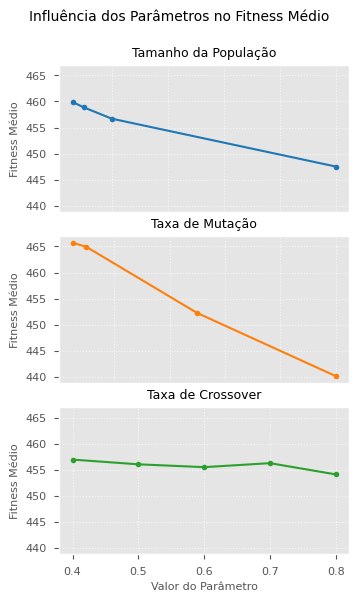

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd # Necessário para o exemplo
import numpy as np # Necessário para o exemplo

# --- Dados de Exemplo (substitua pelos seus dados reais 'df_results') ---
# pop_sizes = [30, 50, 100, 500]
# mutation_rates = [0.005, 0.01, 0.05, 0.1]
# crossover_rates = [0.4, 0.5, 0.6, 0.7, 0.8]
# data = []
# for ps in pop_sizes:
#     for mr in mutation_rates:
#         for cr in crossover_rates:
#             for _ in range(5): # 5 simulações
#                 data.append({'pop_size': ps, 'mutation_rate': mr, 'crossover_rate': cr, 
#                              'max_fitness': 100 - ps/10 - mr*100 - cr*10 + np.random.rand()*5})
# df_results = pd.DataFrame(data)
# -----------------------------------------------------------

# --- Configurações para formato IEEE ---
plt.style.use('seaborn-v0_8-paper')
plt.rcParams.update({
    'font.size': 8, 'axes.labelsize': 8, 'axes.titlesize': 9,
    'xtick.labelsize': 8, 'ytick.labelsize': 8, 'legend.fontsize': 7,
    'figure.titlesize': 10, 'lines.linewidth': 1.5, 'axes.grid': True,
    'grid.linestyle': ':', 'grid.alpha': 0.7,
})

# --- Criação da Figura (3 linhas, 1 coluna) ---
# Largura ~3.5 polegadas, altura ajustada para 3 plots
fig, axes = plt.subplots(3, 1, figsize=(3.5, 6.0), sharey=True) # Compartilha o eixo Y (Fitness)
fig.suptitle('Influência dos Parâmetros no Fitness Médio', fontsize=10) # Título geral opcional

# Plot 1: População
pop_means = df_results.groupby('pop_size')['max_fitness'].mean()
axes[0].plot(pop_means.index, pop_means.values, color='tab:blue', marker='o', markersize=4)
axes[0].set_title('Tamanho da População')
# axes[0].set_xlabel('Tamanho da População') # X-label no último plot
axes[0].set_ylabel('Fitness Médio')
axes[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) # Ocultar ticks X

# Plot 2: Taxa de Mutação
mut_means = df_results.groupby('mutation_rate')['max_fitness'].mean()
axes[1].plot(mut_means.index, mut_means.values, color='tab:orange', marker='o', markersize=4)
axes[1].set_title('Taxa de Mutação')
# axes[1].set_xlabel('Taxa de Mutação') # X-label no último plot
axes[1].set_ylabel('Fitness Médio')
axes[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) # Ocultar ticks X

# Plot 3: Taxa de Crossover
cross_means = df_results.groupby('crossover_rate')['max_fitness'].mean()
axes[2].plot(cross_means.index, cross_means.values, color='tab:green', marker='o', markersize=4)
axes[2].set_title('Taxa de Crossover')
axes[2].set_xlabel('Valor do Parâmetro') # Label genérico para X
axes[2].set_ylabel('Fitness Médio')

# Ajustes Finais
plt.tight_layout(pad=0.5, rect=[0, 0, 1, 0.96]) # Ajustar layout e espaço para suptitle
plt.savefig('images/av1/lineplots_params_ieee.png', dpi=300, bbox_inches='tight')
plt.show()

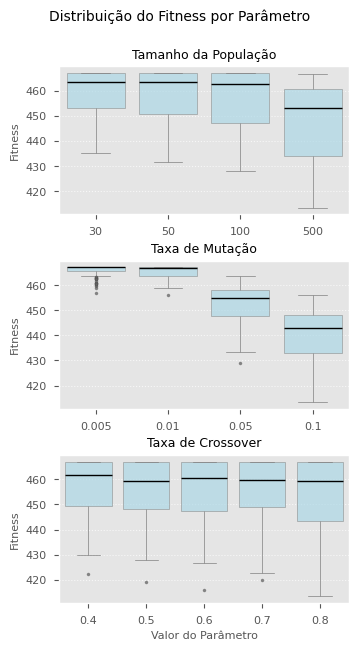

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd # Necessário para o exemplo
import numpy as np # Necessário para o exemplo

# --- Dados de Exemplo (use o mesmo df_results anterior) ---

# --- Configurações para formato IEEE (mesmas do anterior) ---
plt.style.use('seaborn-v0_8-paper')
plt.rcParams.update({
    'font.size': 8, 'axes.labelsize': 8, 'axes.titlesize': 9,
    'xtick.labelsize': 8, 'ytick.labelsize': 8, 'legend.fontsize': 7,
    'figure.titlesize': 10, 'lines.linewidth': 1.0, # Linhas do boxplot mais finas
    'axes.grid': True, 'grid.linestyle': ':', 'grid.alpha': 0.7,
})

# --- Criação da Figura (3 linhas, 1 coluna) ---
fig, axes = plt.subplots(3, 1, figsize=(3.5, 6.5), sharey=True) # Compartilha eixo Y (Fitness)
fig.suptitle('Distribuição do Fitness por Parâmetro', fontsize=10)

# Configurações para os boxplots adaptadas
boxplot_props = {
    'medianprops': dict(color="black", linewidth=1.0),
    'flierprops': dict(marker='.', markersize=3, markerfacecolor='gray', alpha=0.6), # Fliers menores
    'boxprops': dict(facecolor='lightblue', alpha=0.7, edgecolor='gray', linewidth=0.5),
    'whiskerprops': dict(color='gray', linewidth=0.5),
    'capprops': dict(color='gray', linewidth=0.5),
    'showfliers': True # Manter fliers visíveis, mas pequenos
}

# Plot 1: População
sns.boxplot(data=df_results, x='pop_size', y='max_fitness', ax=axes[0], **boxplot_props)
axes[0].set_title('Tamanho da População')
axes[0].set_xlabel(None) # Remover label X redundante
axes[0].set_ylabel('Fitness')

# Plot 2: Taxa de Mutação
sns.boxplot(data=df_results, x='mutation_rate', y='max_fitness', ax=axes[1], **boxplot_props)
axes[1].set_title('Taxa de Mutação')
axes[1].set_xlabel(None) # Remover label X redundante
axes[1].set_ylabel('Fitness')

# Plot 3: Taxa de Crossover
sns.boxplot(data=df_results, x='crossover_rate', y='max_fitness', ax=axes[2], **boxplot_props)
axes[2].set_title('Taxa de Crossover')
axes[2].set_xlabel('Valor do Parâmetro') # Label genérico X no último
axes[2].set_ylabel('Fitness')

# Ajustes Finais
plt.tight_layout(pad=0.5, rect=[0, 0, 1, 0.96])
plt.savefig('images/av1/boxplots_params_ieee.png', dpi=300, bbox_inches='tight')
plt.show()


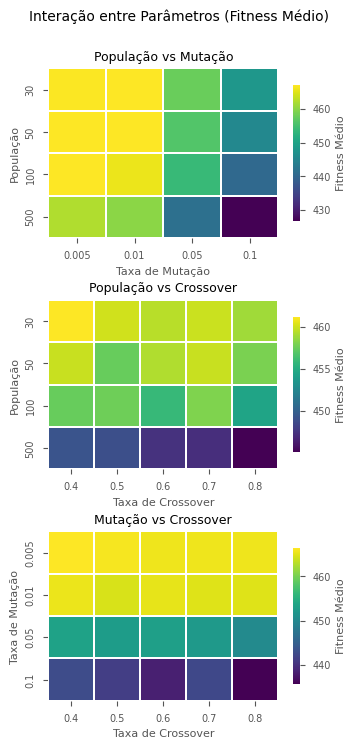

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd # Necessário para o exemplo
import numpy as np # Necessário para o exemplo

# --- Dados de Exemplo (use o mesmo df_results anterior) ---

# --- Configurações para formato IEEE (mesmas do anterior) ---
plt.style.use('seaborn-v0_8-paper')
plt.rcParams.update({
    'font.size': 8, 'axes.labelsize': 8, 'axes.titlesize': 9,
    'xtick.labelsize': 7, 'ytick.labelsize': 7, # Ticks menores para heatmap
    'figure.titlesize': 10, 'axes.grid': False, # Grid geralmente não é usado em heatmaps
})

# --- Criação da Figura (3 linhas, 1 coluna) ---
# A altura pode precisar de mais ajuste dependendo das labels e colorbar
fig, axes = plt.subplots(3, 1, figsize=(3.5, 7.5))
fig.suptitle('Interação entre Parâmetros (Fitness Médio)', fontsize=10)

# Configuração comum para os heatmaps
heatmap_kwargs = {
    'cmap': 'viridis',
    'annot': False, # ANOTAÇÕES REMOVIDAS - ilegíveis em tamanho pequeno
    # 'fmt': '.1f', # Não necessário sem annot=True
    'cbar_kws': {'label': 'Fitness Médio', 'shrink': 0.8}, # Colorbar menor
    'linewidths': 0.2 # Linhas finas
}

# Plot 1: População vs Mutação
pivot_pop_mut = df_results.pivot_table(
    values='max_fitness', index='pop_size', columns='mutation_rate', aggfunc='mean'
)
sns.heatmap(pivot_pop_mut, ax=axes[0], **heatmap_kwargs)
axes[0].set_title('População vs Mutação')
axes[0].set_xlabel('Taxa de Mutação')
axes[0].set_ylabel('População')

# Plot 2: População vs Crossover
pivot_pop_cross = df_results.pivot_table(
    values='max_fitness', index='pop_size', columns='crossover_rate', aggfunc='mean'
)
sns.heatmap(pivot_pop_cross, ax=axes[1], **heatmap_kwargs)
axes[1].set_title('População vs Crossover')
axes[1].set_xlabel('Taxa de Crossover')
axes[1].set_ylabel('População')

# Plot 3: Mutação vs Crossover
pivot_mut_cross = df_results.pivot_table(
    values='max_fitness', index='mutation_rate', columns='crossover_rate', aggfunc='mean'
)
sns.heatmap(pivot_mut_cross, ax=axes[2], **heatmap_kwargs)
axes[2].set_title('Mutação vs Crossover')
axes[2].set_xlabel('Taxa de Crossover')
axes[2].set_ylabel('Taxa de Mutação')

# Ajustes Finais
plt.tight_layout(pad=0.5, rect=[0, 0, 1, 0.96])
plt.savefig('images/av1/heatmaps_params_ieee.png', dpi=300, bbox_inches='tight')
plt.show()

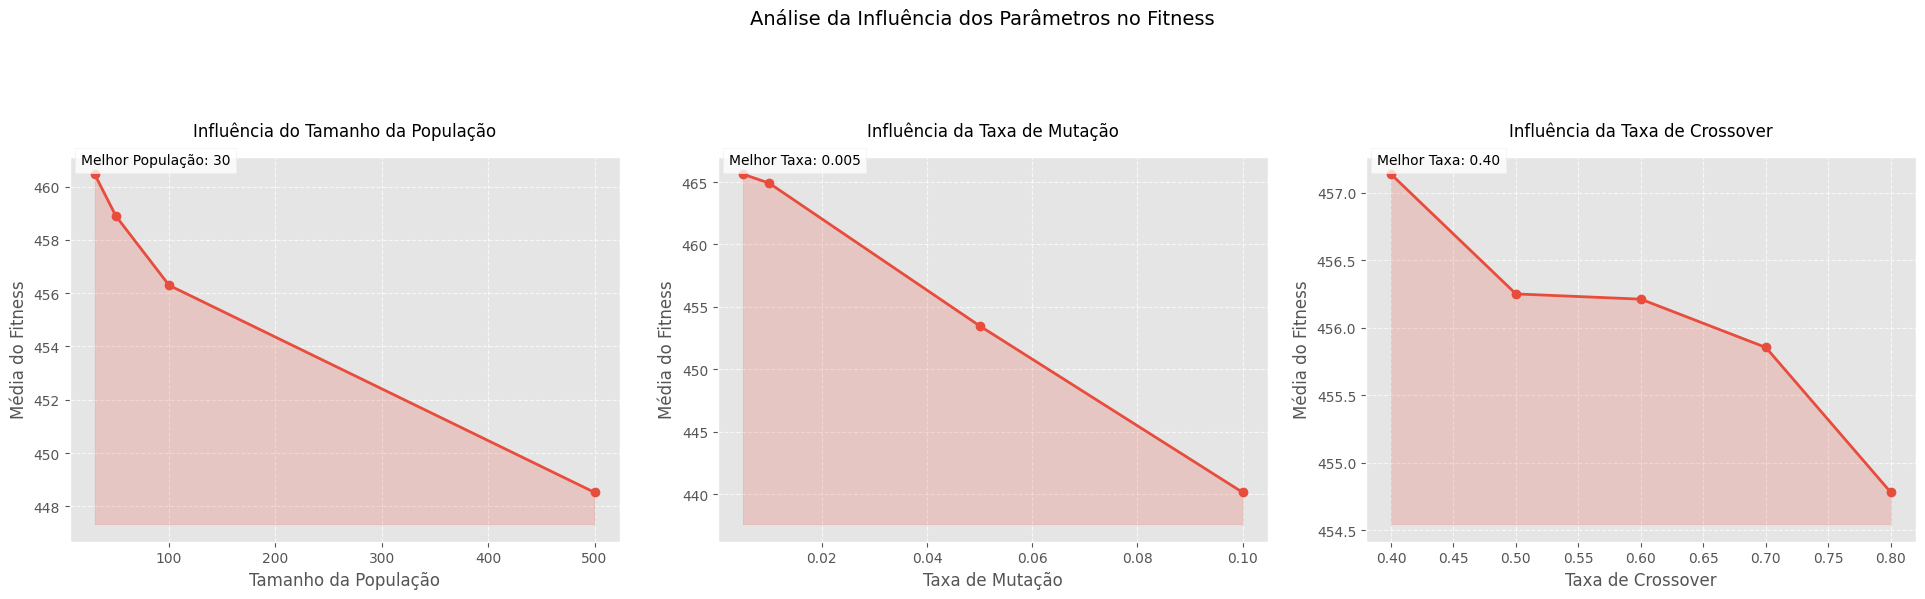

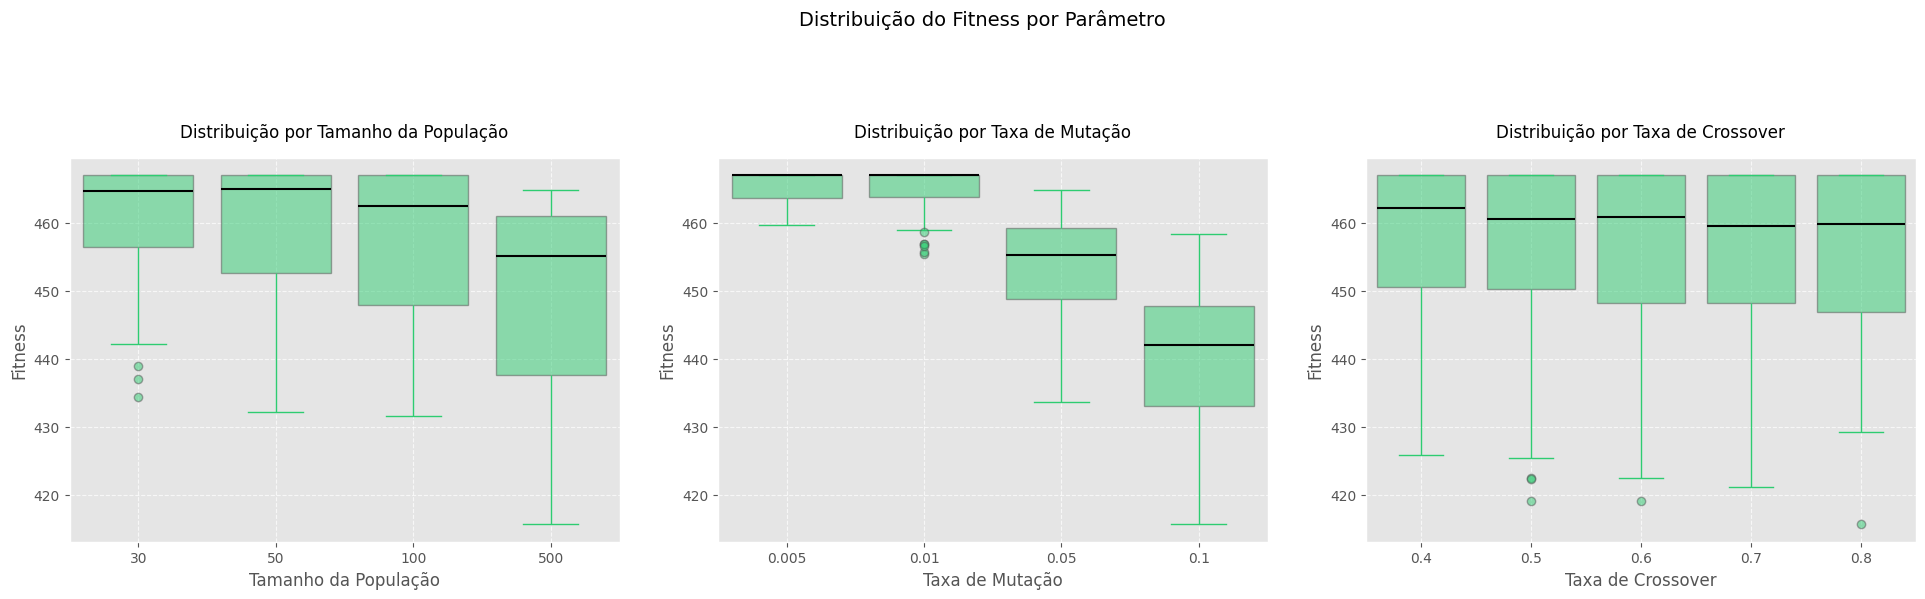

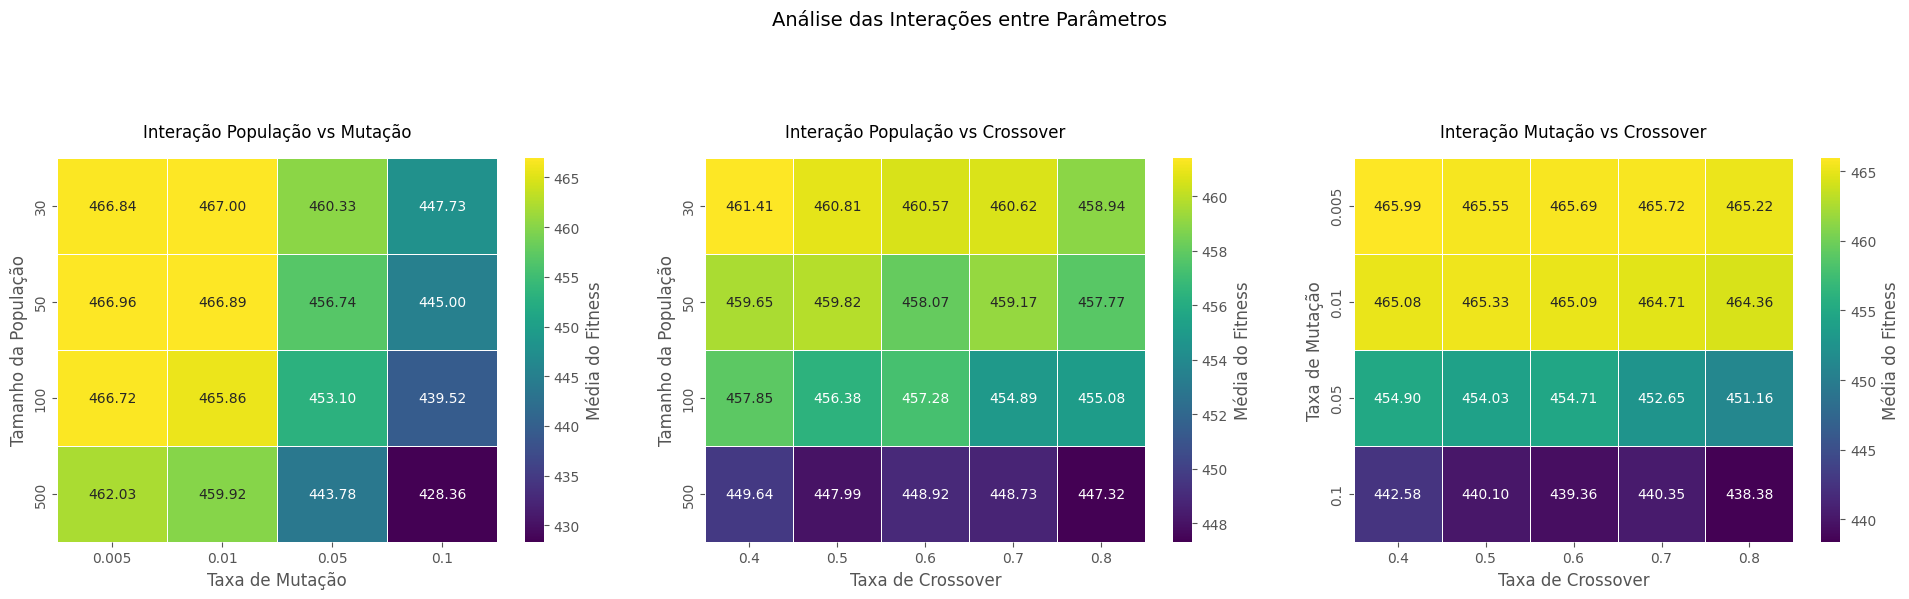

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configurações gerais
plt.style.use('ggplot')
color_boxplot = '#2ecc71'
color_line = '#e74c3c'

# 1. Gráficos de linha
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Análise da Influência dos Parâmetros no Fitness', fontsize=14, y=1.02)
fig.tight_layout(pad=4.0)

# População
pop_means = df_results.groupby('pop_size')['max_fitness'].mean()
axes[0].plot(pop_means.index, pop_means.values, color=color_line, linewidth=2, marker='o')
axes[0].fill_between(pop_means.index, pop_means.values, 
                    min(pop_means.values) - (pop_means.values.max() - pop_means.values.min())*0.1,
                    alpha=0.2, color=color_line)
axes[0].set_title('Influência do Tamanho da População', fontsize=12, pad=15)
axes[0].set_xlabel('Tamanho da População')
axes[0].set_ylabel('Média do Fitness')
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].text(0.02, 0.98, f'Melhor População: {pop_means.idxmax()}', 
             transform=axes[0].transAxes, bbox=dict(facecolor='white', alpha=0.8))

# Taxa de Mutação
mut_means = df_results.groupby('mutation_rate')['max_fitness'].mean()
axes[1].plot(mut_means.index, mut_means.values, color=color_line, linewidth=2, marker='o')
axes[1].fill_between(mut_means.index, mut_means.values,
                    min(mut_means.values) - (mut_means.values.max() - mut_means.values.min())*0.1,
                    alpha=0.2, color=color_line)
axes[1].set_title('Influência da Taxa de Mutação', fontsize=12, pad=15)
axes[1].set_xlabel('Taxa de Mutação')
axes[1].set_ylabel('Média do Fitness')
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].text(0.02, 0.98, f'Melhor Taxa: {mut_means.idxmax():.3f}', 
             transform=axes[1].transAxes, bbox=dict(facecolor='white', alpha=0.8))

# Taxa de Crossover
cross_means = df_results.groupby('crossover_rate')['max_fitness'].mean()
axes[2].plot(cross_means.index, cross_means.values, color=color_line, linewidth=2, marker='o')
axes[2].fill_between(cross_means.index, cross_means.values,
                    min(cross_means.values) - (cross_means.values.max() - cross_means.values.min())*0.1,
                    alpha=0.2, color=color_line)
axes[2].set_title('Influência da Taxa de Crossover', fontsize=12, pad=15)
axes[2].set_xlabel('Taxa de Crossover')
axes[2].set_ylabel('Média do Fitness')
axes[2].grid(True, linestyle='--', alpha=0.7)
axes[2].text(0.02, 0.98, f'Melhor Taxa: {cross_means.idxmax():.2f}', 
             transform=axes[2].transAxes, bbox=dict(facecolor='white', alpha=0.8))

plt.show()

# 2. Boxplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Distribuição do Fitness por Parâmetro', fontsize=14, y=1.02)
fig.tight_layout(pad=4.0)

# Configurações comuns para os boxplots
boxplot_props = {
    'medianprops': dict(color="black", linewidth=1.5),
    'flierprops': dict(marker='o', markerfacecolor=color_boxplot, alpha=0.5),
    'boxprops': dict(facecolor=color_boxplot, alpha=0.5),
    'whiskerprops': dict(color=color_boxplot),
    'capprops': dict(color=color_boxplot)
}

# População
sns.boxplot(data=df_results, x='pop_size', y='max_fitness', ax=axes[0], **boxplot_props)
axes[0].set_title('Distribuição por Tamanho da População', fontsize=12, pad=15)
axes[0].set_xlabel('Tamanho da População')
axes[0].set_ylabel('Fitness')
axes[0].grid(True, linestyle='--', alpha=0.7)

# Taxa de Mutação
sns.boxplot(data=df_results, x='mutation_rate', y='max_fitness', ax=axes[1], **boxplot_props)
axes[1].set_title('Distribuição por Taxa de Mutação', fontsize=12, pad=15)
axes[1].set_xlabel('Taxa de Mutação')
axes[1].set_ylabel('Fitness')
axes[1].grid(True, linestyle='--', alpha=0.7)

# Taxa de Crossover
sns.boxplot(data=df_results, x='crossover_rate', y='max_fitness', ax=axes[2], **boxplot_props)
axes[2].set_title('Distribuição por Taxa de Crossover', fontsize=12, pad=15)
axes[2].set_xlabel('Taxa de Crossover')
axes[2].set_ylabel('Fitness')
axes[2].grid(True, linestyle='--', alpha=0.7)

plt.show()

# 3. Heatmaps
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Análise das Interações entre Parâmetros', fontsize=14, y=1.02)
fig.tight_layout(pad=4.0)

# Configuração comum para os heatmaps
heatmap_kwargs = {
    'cmap': 'viridis',
    'annot': True,
    'fmt': '.2f',
    'cbar_kws': {'label': 'Média do Fitness'},
    'linewidths': 0.5
}

# População vs Mutação
pivot_pop_mut = df_results.pivot_table(
    values='max_fitness', 
    index='pop_size', 
    columns='mutation_rate', 
    aggfunc='mean'
)
sns.heatmap(pivot_pop_mut, ax=axes[0], **heatmap_kwargs)
axes[0].set_title('Interação População vs Mutação', fontsize=12, pad=15)
axes[0].set_xlabel('Taxa de Mutação')
axes[0].set_ylabel('Tamanho da População')

# População vs Crossover
pivot_pop_cross = df_results.pivot_table(
    values='max_fitness', 
    index='pop_size', 
    columns='crossover_rate', 
    aggfunc='mean'
)
sns.heatmap(pivot_pop_cross, ax=axes[1], **heatmap_kwargs)
axes[1].set_title('Interação População vs Crossover', fontsize=12, pad=15)
axes[1].set_xlabel('Taxa de Crossover')
axes[1].set_ylabel('Tamanho da População')

# Mutação vs Crossover
pivot_mut_cross = df_results.pivot_table(
    values='max_fitness', 
    index='mutation_rate', 
    columns='crossover_rate', 
    aggfunc='mean'
)
sns.heatmap(pivot_mut_cross, ax=axes[2], **heatmap_kwargs)
axes[2].set_title('Interação Mutação vs Crossover', fontsize=12, pad=15)
axes[2].set_xlabel('Taxa de Crossover')
axes[2].set_ylabel('Taxa de Mutação')

plt.show()